In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Load the data

In [2]:
df_lights_pd = pickle.load(open('lights_data.pkl','rb'))

In [3]:
df_lights_pd

ADMIN ISO_A3      cam mean_light  year
0           Aruba    ABW  F101992        NaN  1992
1     Afghanistan    AFG  F101992        NaN  1992
2          Angola    AGO  F101992        NaN  1992
3        Anguilla    AIA  F101992        NaN  1992
4         Albania    ALB  F101992        NaN  1992
..            ...    ...      ...        ...   ...
250         Samoa    WSM  F182013   0.814183  2013
251         Yemen    YEM  F182013   0.895347  2013
252  South Africa    ZAF  F182013    1.84181  2013
253        Zambia    ZMB  F182013   0.182403  2013
254      Zimbabwe    ZWE  F182013   0.288358  2013

[8670 rows x 5 columns]

In [4]:
# drop observations without a light value
df_lights_pd = df_lights_pd[~pd.isna(df_lights_pd['mean_light'])]

In [5]:
df_lights_list = []
for year_i in np.unique(df_lights_pd['year']):
    df_lights_list.append(df_lights_pd[df_lights_pd['year'] == year_i])

In [6]:
country_list = np.unique(df_lights_pd['ISO_A3'])
print(f'{len(country_list)} countries in the full dataset')

238 countries in the full dataset


In [7]:
df_lights_analysis = pd.concat(df_lights_list)

In [8]:
df_lights_analysis

ADMIN ISO_A3      cam mean_light  year
0           Aruba    ABW  F101993    30.7313  1993
1     Afghanistan    AFG  F101993  0.0279431  1993
2          Angola    AGO  F101993   0.038532  1993
3        Anguilla    AIA  F101993       9.65  1993
4         Albania    ALB  F101993   0.264269  1993
..            ...    ...      ...        ...   ...
250         Samoa    WSM  F182013   0.814183  2013
251         Yemen    YEM  F182013   0.895347  2013
252  South Africa    ZAF  F182013    1.84181  2013
253        Zambia    ZMB  F182013   0.182403  2013
254      Zimbabwe    ZWE  F182013   0.288358  2013

[8250 rows x 5 columns]

### Cleaning of the data

In [9]:
df_lights_analysis = df_lights_analysis[df_lights_analysis['mean_light'] != 0]
df_sorted = df_lights_analysis.sort_values(['ADMIN','year']).reset_index(drop = True)
df_sorted['mean_light'] = df_sorted['mean_light'].astype('float')
df_differences = df_sorted.groupby('ADMIN').diff()
df_pct = df_sorted.groupby('ADMIN')['mean_light'].pct_change()

### Creating the mean light index

In [10]:
# create time series index for each country
def index_create(g):
    g['mean_light_index'] = np.nan
    start_i = g.head(1).index[0]
    for i, row_i in g.iterrows():
        if i == start_i:
            g.loc[i,'mean_light_index'] = 100
        else:
            g.loc[i,'mean_light_index'] = 100 * (g.loc[i,'mean_light'] / g.loc[start_i,'mean_light'])
        #print(f'''iteration: {i}, val: {g.loc[i,'mean_light_index']}''')
    return g
df_index = df_sorted.groupby("ADMIN").apply(index_create)

In [11]:
df_sorted['mean_light_diff'] = df_differences['mean_light']
df_sorted['mean_light_pct_diff'] = df_pct
df_sorted['mean_light_index'] = df_index['mean_light_index']

### Maps and EDA

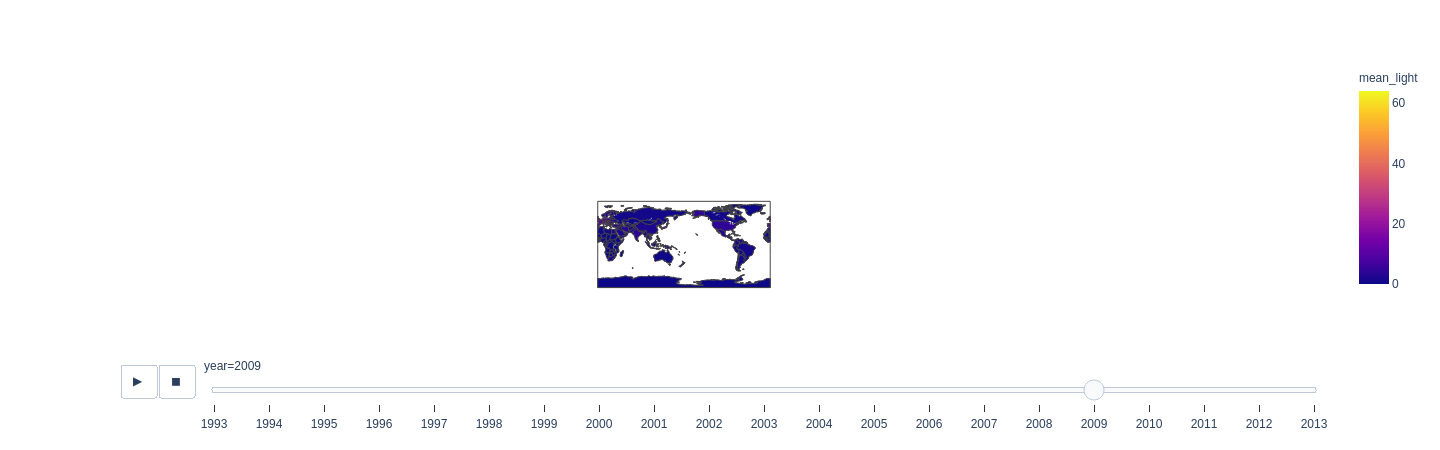

In [13]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light", hover_name="ADMIN", animation_frame="year", range_color=[0,64])
fig.show()

Most of the variety in the colors are a result of just a few countries. Let's see what the distribution looks like more closely.

In [14]:
df_sorted.describe()

mean_light         year  mean_light_diff  mean_light_pct_diff  \
count  8084.000000  8084.000000      7838.000000          7838.000000   
mean      6.858402  2002.403018         0.091761             0.195496   
std      11.641716     5.388954         1.610402             6.587441   
min       0.000299  1993.000000       -15.200000            -0.998310   
25%       0.294316  1998.000000        -0.157347            -0.118714   
50%       1.754660  2002.000000         0.004904             0.023089   
75%       7.888537  2006.000000         0.307163             0.185157   
max      62.947899  2013.000000        15.800000           563.542045   

       mean_light_index  
count       8084.000000  
mean         205.916283  
std          372.201015  
min            0.310171  
25%          109.118442  
50%          141.918805  
75%          198.035601  
max        10433.333333

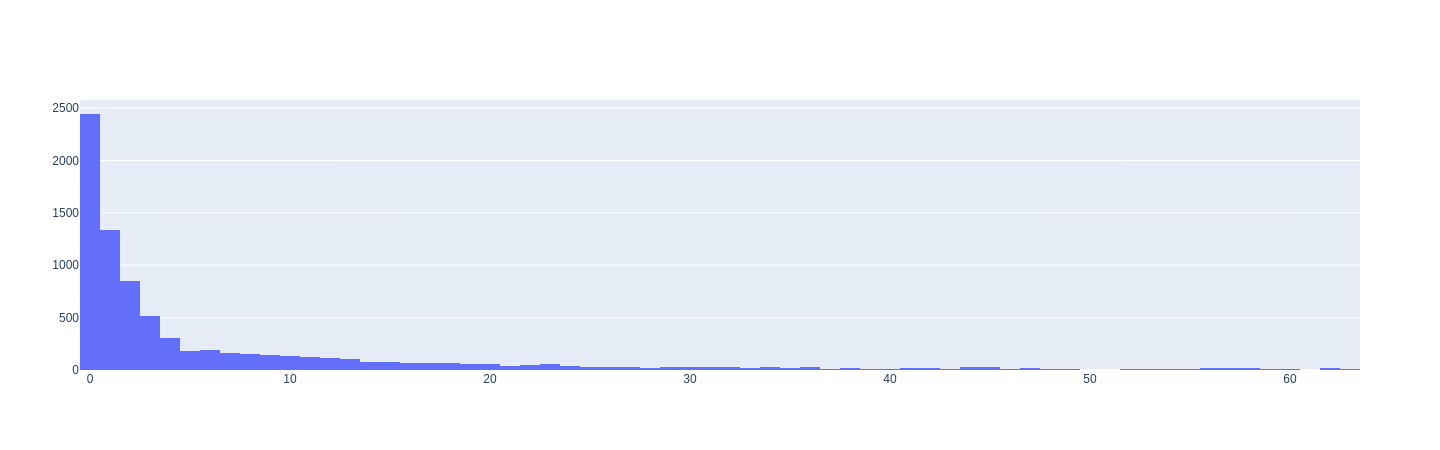

In [15]:
fig = go.Figure(data=[go.Histogram(x=df_sorted['mean_light'])])

fig.show()

Since most of the distribution is below 10. We're going to view the map with 10 as the max and not see differences past that point.

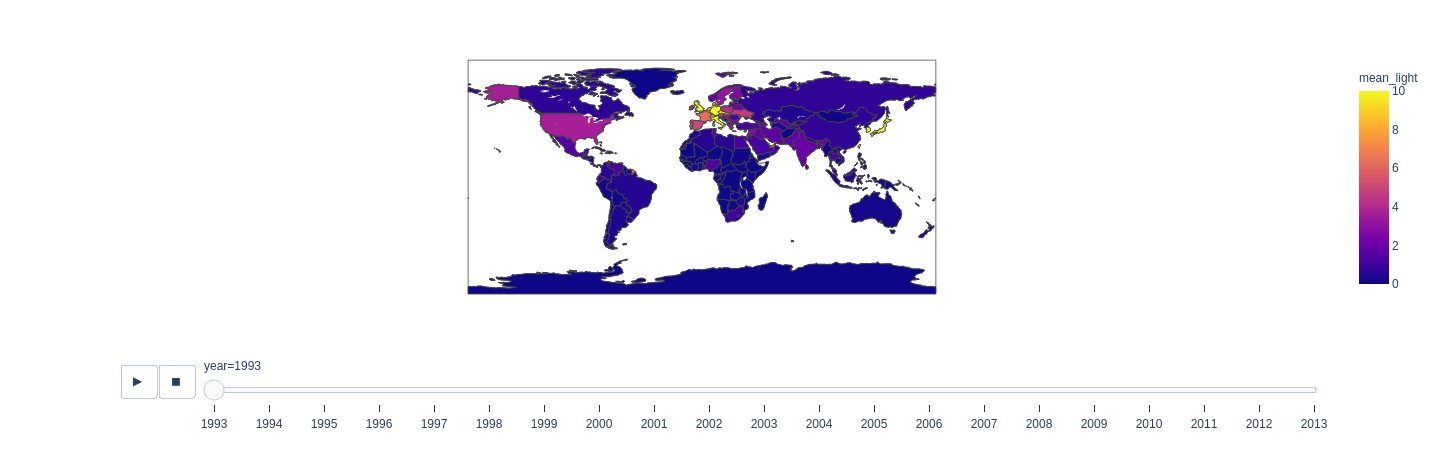

In [16]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light", hover_name="ADMIN", animation_frame="year", range_color=[0,10])
fig.show()

In [17]:
plotly.offline.plot(fig, filename='light.html')

'light.html'

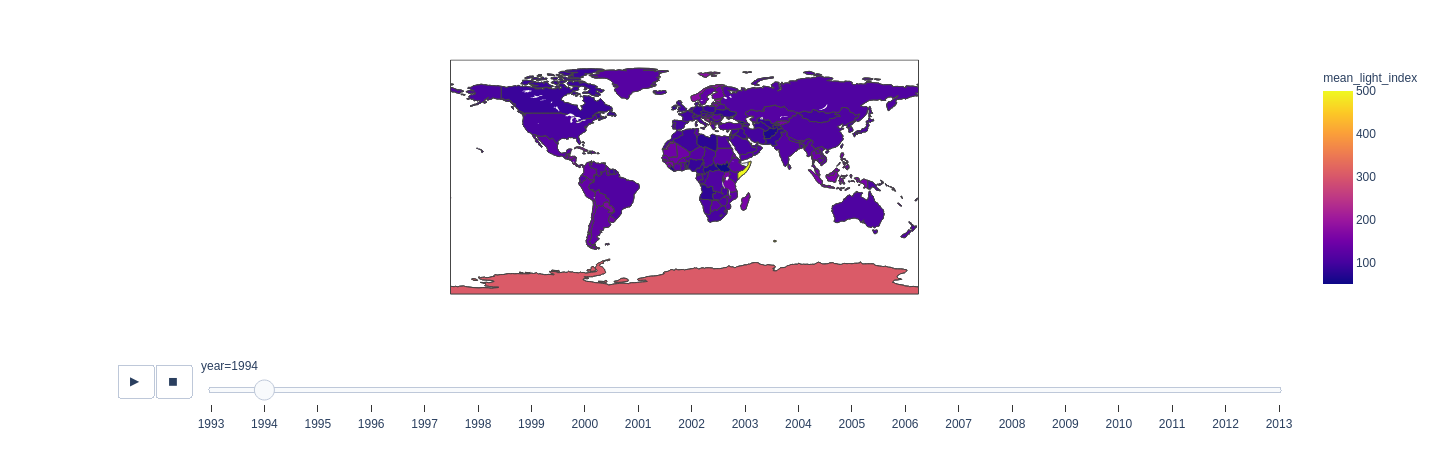

In [22]:
fig = px.choropleth(df_sorted, locations="ISO_A3", color="mean_light_index", hover_name="ADMIN", animation_frame="year", range_color=[50,500])
fig.show()

In [24]:
plotly.offline.plot(fig, filename='light_index.html')

'light_index.html'

In [24]:
pickle.dump(df_sorted, open('lights_data_prep.pkl','wb'))

### Consider changes for a few developing countries

In [18]:
dev_countries= ['India','China','North Korea',
                 'Bangladesh','Thailand',
                 'Philippines','Indonesia','Russia',
                'Brazil','South Africa','Vietnam','Malaysia','Laos'
               ]

df_dev_countries = df_sorted[df_sorted['ADMIN'].isin(dev_countries)]

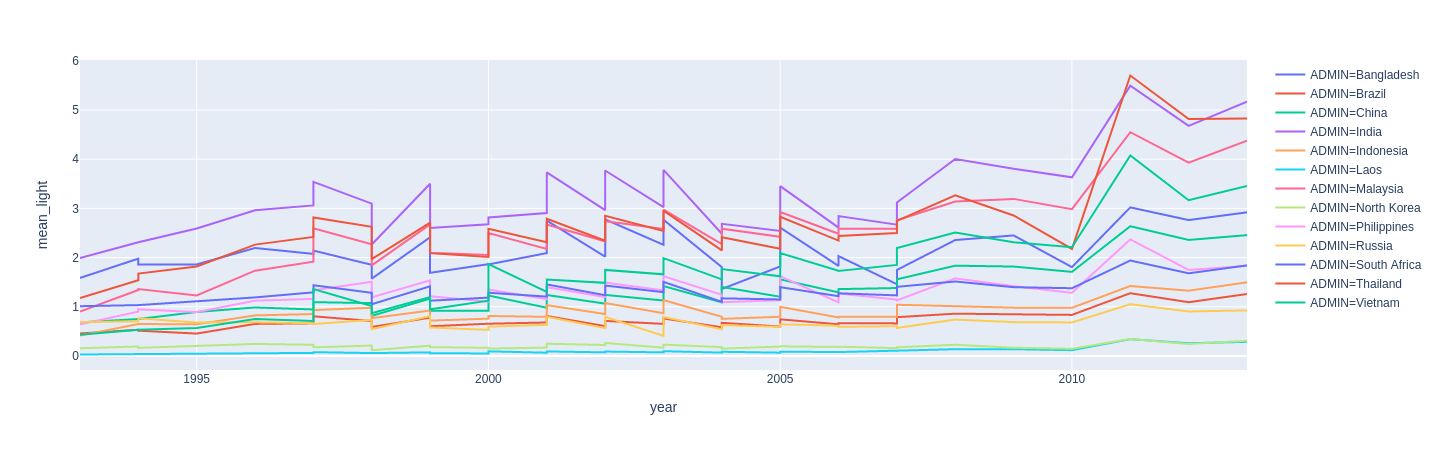

In [19]:
fig = px.line(df_dev_countries, x = 'year', y = 'mean_light', 
              color = 'ADMIN', line_group = 'ADMIN', hover_name = 'ADMIN')
fig.show()

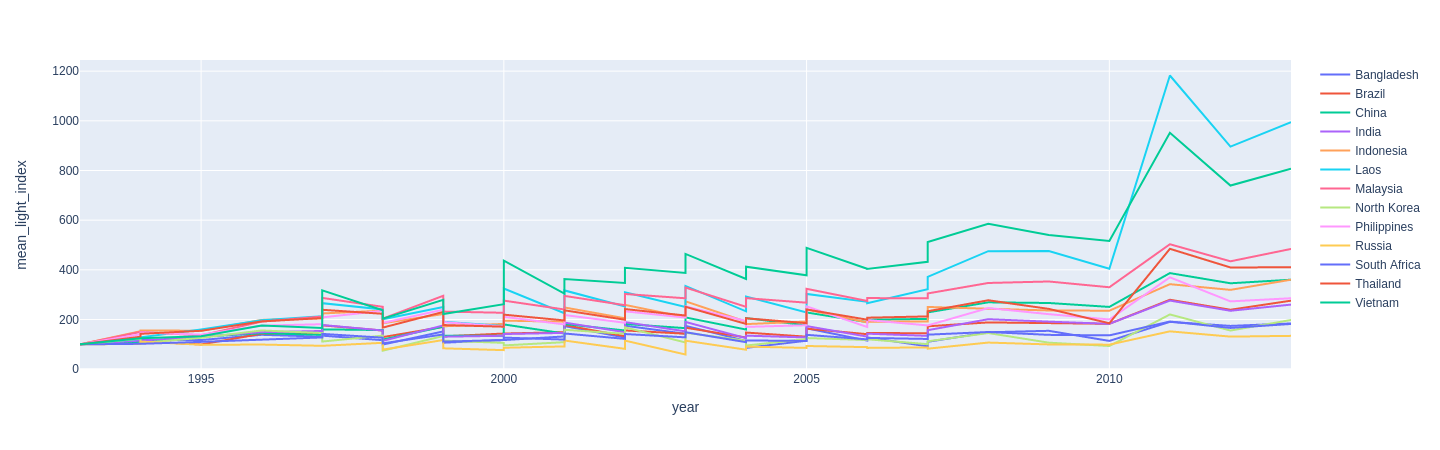

In [20]:
fig = px.line(df_dev_countries, x = 'year', y = 'mean_light_index', 
              color = 'ADMIN')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show()

In [25]:
df_sorted.to_csv('lights_data.csv', index = False)